In [1]:
import pandas as pd
import lightgbm as lgb
import load_datasets
import os

# Load data

In [12]:
training_name = 'lightgbm'
X_train, y_train = load_datasets.train()
X_val, y_val = load_datasets.val()
X_test = load_datasets.test()


feature_name = X_train.columns.tolist()
lgb_train = lgb.Dataset(X_train[feature_name], y_train)
lgb_eval = lgb.Dataset(X_val[feature_name], y_val, reference=lgb_train)

# Train the model

In [6]:
params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'bagging_fraction': 0.75,
               'learning_rate': 0.005,
               'objective': 'mse',
               'bagging_seed': 2**7,
               'num_leaves': 2 ** 7 - 1,
               'bagging_freq': 5
              }

cat_feature_names = [ 
                        'shop_category', 
                        'type_code',
                        'subtype_code', 
                        'shop_city',
]
evals_result = {}
model = lgb.train(
            params, 
            lgb_train,
            num_boost_round=1000,
            valid_sets=(lgb_train, lgb_eval), 
            feature_name = feature_name,
            categorical_feature = cat_feature_names,
            verbose_eval=5, 
            evals_result = evals_result,
            early_stopping_rounds = 30)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['shop_category', 'shop_city', 'subtype_code', 'type_code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds
[5]	training's rmse: 1.19934	valid_1's rmse: 1.12662
[10]	training's rmse: 1.18663	valid_1's rmse: 1.11672
[15]	training's rmse: 1.17463	valid_1's rmse: 1.10764
[20]	training's rmse: 1.1624	valid_1's rmse: 1.09824
[25]	training's rmse: 1.15069	valid_1's rmse: 1.08923
[30]	training's rmse: 1.13967	valid_1's rmse: 1.08077
[35]	training's rmse: 1.12851	valid_1's rmse: 1.07262
[40]	training's rmse: 1.11784	valid_1's rmse: 1.06455
[45]	training's rmse: 1.10757	valid_1's rmse: 1.05691
[50]	training's rmse: 1.09767	valid_1's rmse: 1.04931
[55]	training's rmse: 1.08809	valid_1's rmse: 1.04165
[60]	training's rmse: 1.07887	valid_1's rmse: 1.03493
[65]	training's rmse: 1.07002	valid_1's rmse: 1.02846
[70]	training's rmse: 1.06144	valid_1's rmse: 1.02203
[75]	training's rmse: 1.05315	valid_1's rmse: 1.01611
[80]	training's rmse: 1.04534	valid_1's rmse: 1.01051
[85]	training's rmse: 1.03781	valid_1's rmse: 1.00504
[90]	training's rmse: 1

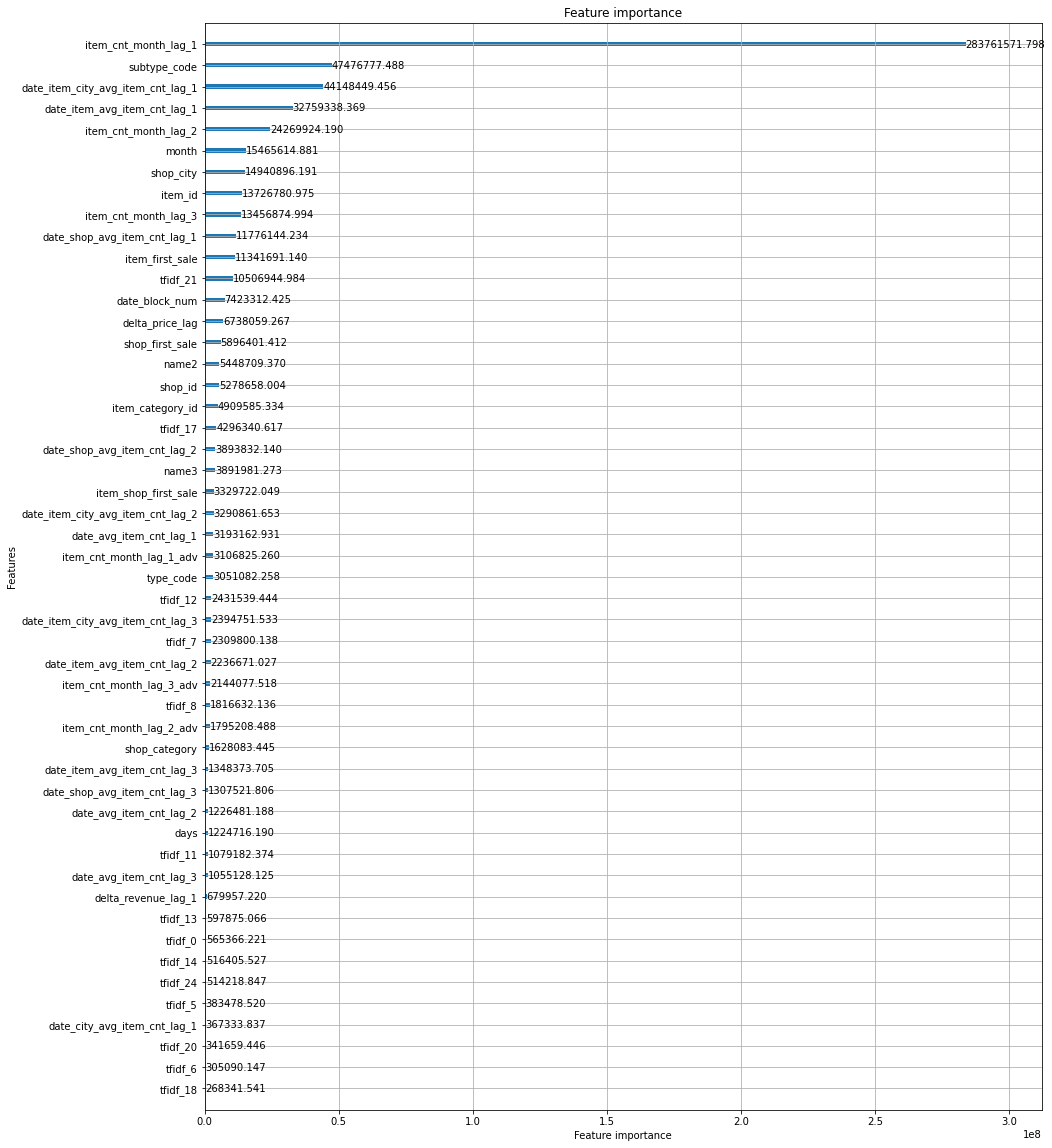

In [9]:
lgb.plot_importance(
    model, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(15,20));

# Make Prediction

In [10]:

DATA_DIR = "data"
OUTPUT_DIR = 'output'


pred_lgb = model.predict(X_test[feature_name])


pred = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
pred['item_cnt_month'] = pred_lgb
pred['item_cnt_month'] = pred['item_cnt_month'].clip(lower=0, upper=20)
pred.to_csv(os.path.join(OUTPUT_DIR, training_name+'.csv'), index=False)

Your public LB scores are: 0.882547

In [20]:
# predict for val, and test for emsembling
pred_val = model.predict(X_val[feature_name])
pd.DataFrame({training_name + 'val': pred_val}).to_hdf(os.path.join(OUTPUT_DIR, training_name+'.h5'), key='val', mode='a')
pd.DataFrame({training_name + 'test': pred_lgb}).to_hdf(os.path.join(OUTPUT_DIR, training_name+'.h5'), key='test', mode='a')

In [21]:
!ls -lht output

total 1.2G
-rw-r--r-- 1 root root 7.0M Aug 30 23:35 lightgbm.h5
-rw-r--r-- 1 root root 5.4M Aug 30 23:17 lightgbm.csv
-rw-r--r-- 1 root root 1.2G Aug 30 21:06 feat_mat.h5


In [23]:
model.save_model(os.path.join(OUTPUT_DIR, 'lgb_model.mdl'))
# model = lgb.Booster(model_file='lgb_model.mdl')